#### Imports, check that GPU is used

In [1]:
! nvcc  --version
! pip install tensorflow keras --quiet
! pip install keras-tuner --quiet
! pip install seaborn --quiet
! pip install kaggle --quiet

! pip install pyyaml h5py  # Required to save models in HDF5 format

# needed for AugMix (removed)
# !pip install keras-cv --quiet

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [2]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers

import keras_tuner as kt
# from keras_cv.layers import AugMix

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

2025-05-21 10:14:03.123515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747822443.138782   67964 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747822443.143620   67964 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747822443.156427   67964 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747822443.156454   67964 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747822443.156457   67964 computation_placer.cc:177] computation placer alr

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())
#assert len(tf.config.list_physical_devices('GPU')) > 0

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Dataset preparation

The dataset contains 2 folders
*   Infected
*   Parasitized
And a total of 27,558 images.
Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
And uploaded here, so anybody trying to start working with this dataset can get started immediately, as to download the
dataset from NIH website is quite slow.

#### Loading, splitting, standardizing the dataset and getting class names

In [30]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [31]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  # shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)
print("Actually the last one is the test set (issue of keras.utils function)")

Loading and splitting the tf_dataset


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.
Actually the last one is the test set (issue of keras.utils function)


In [32]:
# getting the class names
classes = train_set.class_names
num_classes = len(classes)
print(f'[0={classes[0]}, 1={classes[1]}]')

[0=Parasitized, 1=Uninfected]


#### Compute some dataset statistics

In [33]:

# calculates how many images there are for each class
def num_img_per_class(dataset):
  class_counts = collections.Counter()
  for _, labels in dataset:
      class_indices = labels.numpy().squeeze().astype(int)  # (batch_size, 1) → (batch_size,)
      class_counts.update(map(int, class_indices))
  return class_counts

# Get counts
train_class_counts = num_img_per_class(train_set)
val_class_counts = num_img_per_class(test_set)
print('Training set:', train_class_counts)
print('Validation set:', val_class_counts)

Training set: Counter({0: 11070, 1: 10977})
Validation set: Counter({1: 2802, 0: 2709})


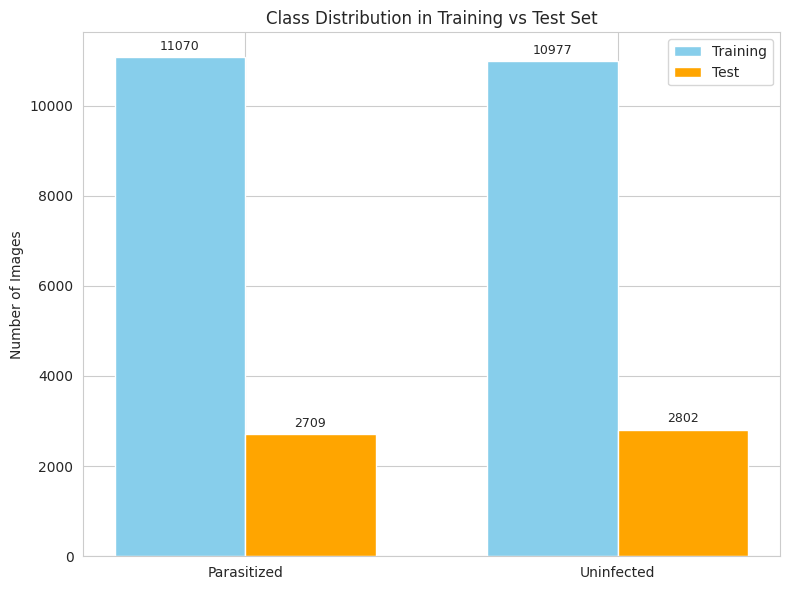

In [34]:
# bar diagram of training and validation classes distribution
labels_map = {0: 'Parasitized', 1: 'Uninfected'}

# Prepare data
x_labels = [labels_map[i] for i in sorted(labels_map.keys())]
x_pos = range(len(x_labels))
train_vals = [train_class_counts[i] for i in sorted(labels_map.keys())]
val_vals = [val_class_counts[i] for i in sorted(labels_map.keys())]

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plot bars
bar_width = 0.35
bars1 = plt.bar([i - bar_width/2 for i in x_pos], train_vals, width=bar_width, label='Training', color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x_pos], val_vals, width=bar_width, label='Test', color='orange')

# Add counts on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(ticks=x_pos, labels=x_labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training vs Test Set")
plt.legend()
plt.tight_layout()
plt.show()

As you can see the class distribution is almost identical both for the training set and test set.
We will now show some images

/tmp/ipykernel_67964/1356102884.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)


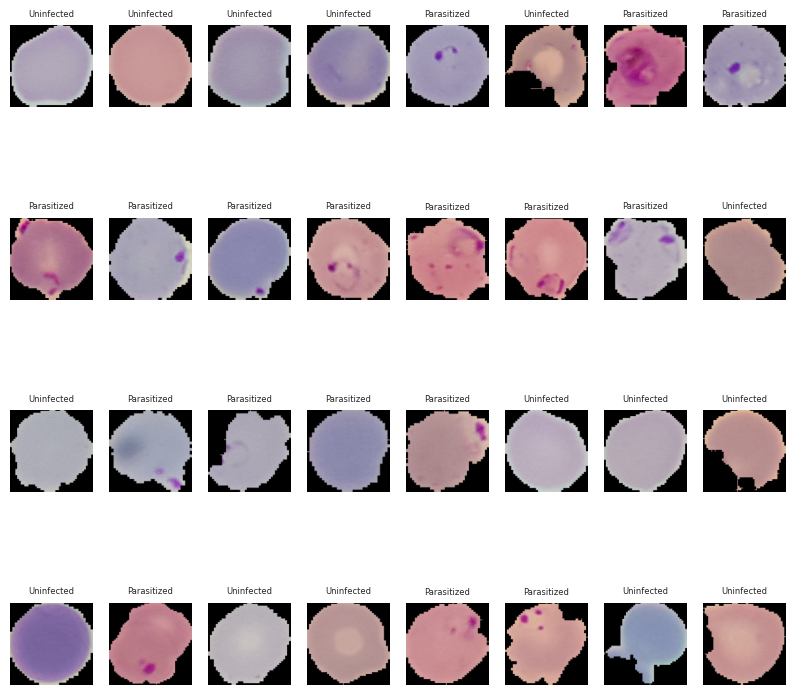

In [35]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy()).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()

#### Data augmentation (custom pipeline)

We will now extend (double) the training dataset by adding images obtained with various data augmentation techniques. The augmented dataset is merged with the training set to enalrge it. At last, the merged dataset is normalized.

In [36]:

# we have discovered that AugMix, which has great theoretical performances does not work well
# on our medical images as it introduces too many color variations, so we moved to a more
# conventional data augmentation pipeline
# AugMix(
#         severity=1,
#         chain_depth=1,
#         alpha=0.1,
#         value_range=(0, 255),
#     ),
# see https://arxiv.org/abs/1912.02781 for details on AugMix

preprocessing = keras.Sequential([
    # geometric transformations
    layers.RandomRotation(factor=0.2),
    layers.RandomFlip(mode='horizontal_and_vertical'),

    # illumination transformations
    layers.RandomBrightness(factor=0.15),
    layers.RandomContrast(factor=0.15),

    # some noise
    layers.GaussianNoise(stddev=0.05),
    #layers.Rescaling(1./255), # data standardization
])

augmented_dataset = train_set.map(lambda x, y: (preprocessing(x), y))
# concatenate the two datasets to form a big one
train_set = train_set.concatenate(augmented_dataset)

print('Augmented train set size:', augmented_dataset.cardinality().numpy()*batch_size)
print('Merged train set size:', train_set.cardinality().numpy()*batch_size)



Augmented train set size: 22048
Merged train set size: 44096


Do not rerun this cell on its own otherwise the dataset doubles each time

Now we standardize the training set as well as the merged dataset

In [37]:
train_set = train_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9257621
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9129691
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9201287
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.95675886
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9336079


The images are preprocessed and standardized

/tmp/ipykernel_67964/2243483184.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)


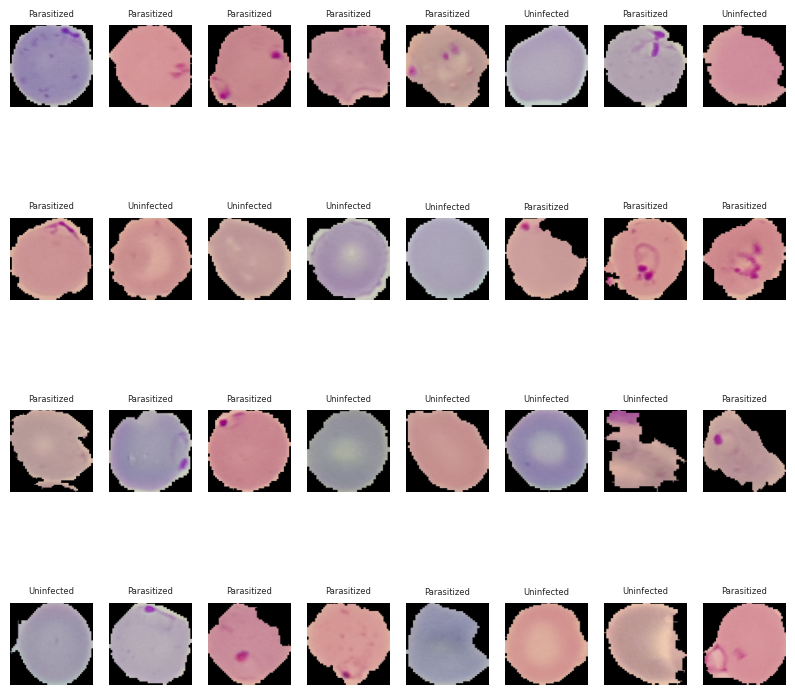

In [38]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()


As you can see the images are changed

### Model selection using KerasTuner, training and testing


1. hyperparameter tuning (using train_reduced, val_set)
2. retraining the best model on the entire train_set 
3. testing the model
4. saving the model



#### Hyperparameter tuning

In [13]:
# function needed by KerasTuner to automatically select the best parameter
# values according to the validation loss

def model_builder(hp):
    input_shape = (128, 128, 3) # Height, Width, Channels (RGB)
    hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])
    
    model = keras.Sequential()
    
    # block 1
    model.add(layers.Input(input_shape))
    model.add(
        layers.SeparableConv2D(
            filters=hp.Int('c1_filters', min_value=16, max_value=40, step=8), 
            kernel_size=(3, 3), 
            activation=hp_activation, 
            padding='same',
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2))) # 64x64x16
    model.add(layers.Dropout(hp.Float('drop_1', min_value=0.0, max_value=0.4, step=0.025)))


    # block 2
    model.add(
        layers.SeparableConv2D(
            hp.Int('c2_filters', min_value=32, max_value=54, step=8), 
            kernel_size=(3, 3), 
            activation=hp_activation, 
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2))) # 32x32x32
    model.add(layers.Dropout(hp.Float('drop_2', min_value=0.0, max_value=0.4, step=0.05)))

    # block 3
    model.add(
        layers.SeparableConv2D(
            filters=hp.Int('c3_filters', min_value=48, max_value=72, step=8), 
            kernel_size=(3, 3), 
            activation=hp_activation, 
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2))) # 16x16x48
    model.add(layers.Dropout(hp.Float('drop_3', min_value=0.0, max_value=0.4, step=0.025)))


    # block 4
    model.add(
        layers.SeparableConv2D(
            filters=hp.Int('c4_filters', min_value=64, max_value=88, step=8), 
            kernel_size=(3, 3), 
            activation=hp_activation, 
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2))) # 8x8x64
    model.add(layers.Dropout(hp.Float('drop_4', min_value=0.0, max_value=0.4, step=0.025)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layer
    model.add(
        layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
            activation=hp_activation
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('drop_dense', min_value=0.0, max_value=0.5, step=0.025)))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))


    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    lrate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')

    # defaults to adam
    optimizer = keras.optimizers.Adam()
    match optimizer_choice:
        case 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lrate)
        case 'sgd':
            optimizer = keras.optimizers.SGD(learning_rate=lrate)
        case 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=lrate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

    

In [14]:
# split train into train_reduced/val
train_size = int(train_set.cardinality().numpy() * 0.8)
train_reduced = train_set.take(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = train_set.skip(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Verify the split (Optional)
print("Reduced training dataset size:", train_reduced.cardinality().numpy()*batch_size)
print("Validation dataset size:", val_set.cardinality().numpy()*batch_size)

Reduced training dataset size: 35264
Validation dataset size: 8832


In [15]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_epochs=6,
    factor = 3,
    directory = 'tuned_models',
    project_name='malaria_det'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(train_reduced, epochs=100, validation_data=val_set, callbacks=[stop_early])

Reloading Tuner from tuned_models/malaria_det/tuner0.json


#### Re-train the best model on the entire train_set

In [16]:
# cache and prefetch for faster training
train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Get the best model
best_params = tuner.get_best_hyperparameters(num_trials=3)[0]

# create the best model found
best_model = tuner.hypermodel.build(best_params)

In [24]:
# retrain the best model on the entire training set
stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = best_model.fit(train_set, epochs=30, callbacks=[stop_early])

Epoch 1/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8680 - loss: 0.3205
Epoch 2/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9502 - loss: 0.1515
Epoch 3/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9537 - loss: 0.1423
Epoch 4/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9559 - loss: 0.1373
Epoch 5/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9561 - loss: 0.1352
Epoch 6/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9566 - loss: 0.1307
Epoch 7/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9576 - loss: 0.1278
Epoch 8/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9582 - loss: 0.1250
Epoch 9/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9598 - loss: 0.1218
Epoch 10/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9596 - loss: 0.1209
Epoch 11/30
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9605 - loss: 0.1198
Epoch 12/30
1378/1378 ━━━━━━━

if you want to avoid retraining (very long process) here are the statistics
training accuracy: 0.9682 - loss: 0.0921

Saving the model in an h5 format

In [25]:
# Save the entire model as a SavedModel.
! mkdir -p saved_model
keras.saving.save_model(best_model, 'saved_model/malaria_det.keras')

### Testing the model on the test_set

Standardize, cache and prefetch the test set for performance

In [39]:
test_set = test_set.map(lambda x, y: (x/255, y))
for image, _ in test_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.95924455
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.972263
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9201294
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9355699
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9841912


To make this code runnable even without retraining the model we load it from the saved file

In [40]:
# load on the same variable to save memory
best_model = keras.saving.load_model('saved_model/malaria_det.keras')

After training the model we have achieved a training accuracy of 0.96.. (hardcoded value! may vary slighly), we now test it on the test_set to get an estimate of the generalization error. It may take a while as the test set is composed of more than 5K images.

In [41]:
# Evaluate it on the test set
loss, accuracy = best_model.evaluate(test_set, verbose=0)

print(f'Best model test loss: {loss:.4f}')
print(f'Best model test accuracy: {accuracy:.4f}')

Best model test loss: 0.1665
Best model test accuracy: 0.9563


### Some model stats

#### Model summary

In [42]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_4              │ (None, 128, 128, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 64, 64, 32)     │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 32, 32, 56)     │         2,136 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 56)     │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 16, 16, 88)     │         5,520 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 88)     │           352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 88)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 88)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 88)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         8,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 96)             │             

 Total params: 55,822 (218.06 KB)

 Trainable params: 18,404 (71.89 KB)

 Non-trainable params: 608 (2.38 KB)

 Optimizer params: 36,810 (143.79 KB)

#### Precision/Recall/F1-score and AUC-ROC

Once again this operation may take a while as the test set is composed of lots of images!

In [43]:
# testing the model performance on the test_set
# to get an estimate of the generalization error
y_true = []
y_probs = []

for x_batch, y_batch in test_set:
    preds = best_model.predict(x_batch, verbose=0).ravel()
    y_probs.extend(preds)
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = (y_probs > 0.5).astype(int)

In [44]:
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))
print(f"AUC-ROC: {roc_auc_score(y_true, y_probs):.4f}")

              precision    recall  f1-score   support

  Uninfected       0.99      0.93      0.95      2709
 Parasitized       0.93      0.99      0.96      2802

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511

AUC-ROC: 0.9918


We now plot the ROC curve

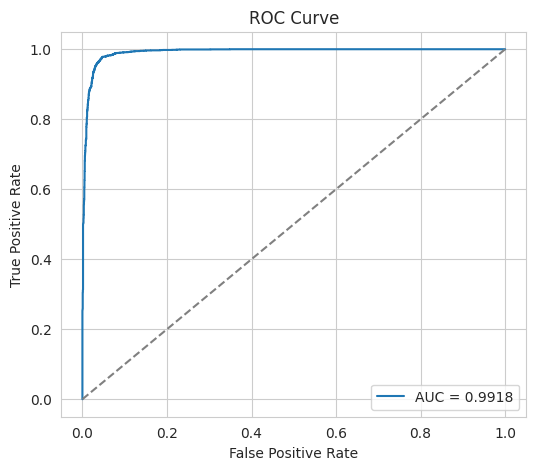

In [45]:
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

We now plot the precision/recall curve

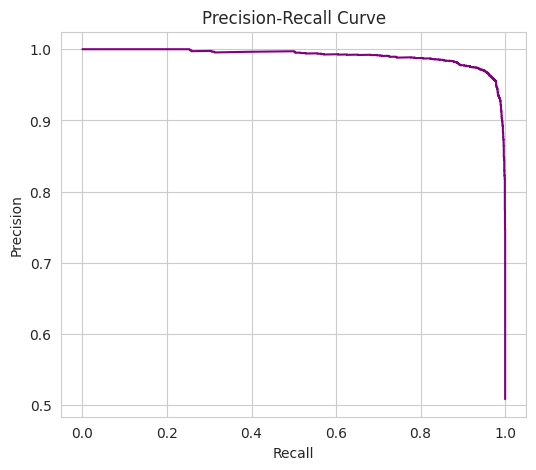

In [46]:
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

#### Confusion matrix

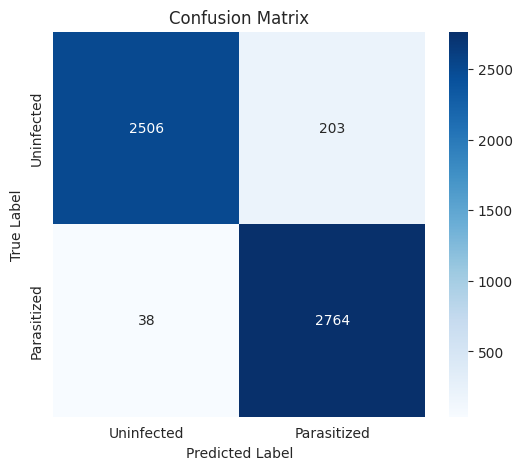

In [47]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()